In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm

import matplotlib.patches as mpatches

from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression

pd.set_option('display.max_columns', None)

coeffs = ['IP', 'BT', 'NEL', 'PLTH', 'RGEO', 'KAREA', 'EPS', 'MEFF']
path = "../data/"

In [3]:
# REMARK: There are no spherical TOKAMAKs in these analyses.  

DB2P8 = pd.read_csv(path+"DB2P8.csv")
DB5 = pd.read_csv(path+"DB5.csv")

DB2P8 = DB2P8[DB5.columns]

# How was this chosen? Is this a form of removing outliers or noise to the new regression?
# Why not simply use the whole DB5?
new_ids = pd.read_csv(path+"new_point_ids.csv")
                  
R = pd.read_csv(path+"R.csv") #DB5[DB5.id.isin(new_ids.id.values)] #reintroduce dataset

DB2 = DB2P8[["TAUTH"] + coeffs].apply(np.abs).apply(np.log)
DB2["id"] = DB2P8["id"]

reg_data = pd.read_csv(path+"data.csv")

In [4]:
def get_regression_np(_R):
    data = pd.concat([DB2, _R],
                     axis=0, 
                     ignore_index=True
                    )
    Y_ = data[["TAUTH"]].to_numpy()
    # Adding a column for the intercept
    _df = data[coeffs]; _df.insert(
        loc = 0, 
        column = "intercept", 
        value = np.ones(len(_df))
    )
    X_ = _df.to_numpy()
    n_, p_ = X_.shape
    model = sm.OLS(Y_,X_)
    regression = model.fit()
    return data, regression, (n_,p_)

# Getting regression of DB2P8 only. 
regression_DB2 = get_regression_np(R[R.id.isin([0])])[1]
#regression_DB2.summary()

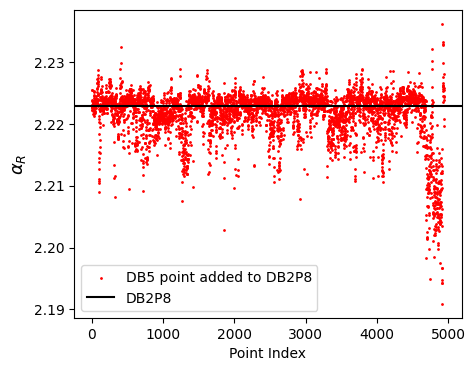

In [5]:
plt.figure(figsize=(5,4))
plt.scatter(reg_data.index, reg_data.αR, s=1, c="r", label="DB5 point added to DB2P8")
plt.axhline(regression_DB2.params[5], c="k", label="DB2P8")
plt.xlabel("Point Index")
plt.ylabel("$\\alpha_R$", fontsize=13)
plt.legend();

In [6]:
# Leave the ones above baseline out -- because we are interested in the reduction of value
pts_minimize = reg_data[reg_data.αR < regression_DB2.params[5] ]
pts_minimize = pts_minimize.sort_values("αR", ascending=True)


# Ordering dataset ids from smallest to greatest alpha-R 

dict_ordered_vals = dict(zip( 
    pts_minimize.id_added.values, 
    list(range(len(pts_minimize)))  
) )

DB5_decreas_pts = R[R.id.isin(pts_minimize.id_added)]
DB5_decreas_pts.insert(0, "ordered", DB5_decreas_pts.id.map(dict_ordered_vals))

DB5_decreas_pts = DB5_decreas_pts.sort_values("ordered")
DB5_decreas_pts = DB5_decreas_pts.set_index("ordered")

In [7]:
reg_coeff_per_pts = np.zeros(len(pts_minimize))
for i in range(1, len(pts_minimize) + 1):
    # Adding one point at a time to DB2P8 from DB5 od decreasing subset in an ordered manner.
    R_ = (DB5_decreas_pts.iloc[:i][["TAUTH"] + coeffs])
    # Storing regression coefficient for alpha_R only
    reg_coeff_per_pts[i-1] = get_regression_np(R_)[1].params[5]
    
DB5_decreas_pts["αR_per_pts_in_DB2"] = reg_coeff_per_pts

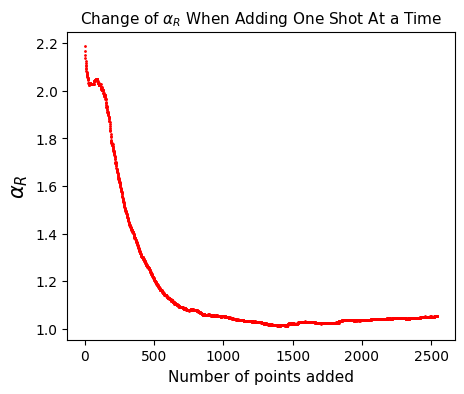

In [8]:
#%matplotlib notebook

plt.figure(figsize=(5,4))
plt.scatter(DB5_decreas_pts.index + 1, DB5_decreas_pts["αR_per_pts_in_DB2"], s=1, c = "r")
plt.xlabel("Number of points added", fontsize=11)
plt.ylabel("$\\alpha_R$", fontsize=15)
plt.title("Change of $\\alpha_R$ When Adding One Shot At a Time", fontsize=11);

In [17]:
big_dataset = pd.read_csv(path+"decreased_dataset_random_sampling_500.csv")
small_dataset = pd.read_csv(path+"decreased_dataset_random_sampling_500_decreasing_points.csv")
small_dataset = small_dataset.set_index("seed")

In [20]:
small_dataset#.index

subset_1  subset_2  subset_3  subset_4  subset_5  subset_6  subset_7  \
seed                                                                          
213    2.215572  2.214411  2.213288  2.210325  2.208332  2.206146  2.201165   
284    2.221454  2.211021  2.191375  2.190254  2.180881  2.178043  2.169503   
355    2.215709  2.211692  2.210587  2.201233  2.199046  2.197661  2.194923   
426    2.221590  2.217022  2.213837  2.209614  2.207182  2.204887  2.198852   
497    2.221761  2.219649  2.212420  2.208887  2.207775  2.203809  2.201989   
...         ...       ...       ...       ...       ...       ...       ...   
35358  2.209594  2.205669  2.203072  2.202225  2.198667  2.192961  2.187251   
35429  2.219987  2.214565  2.207287  2.205088  2.197184  2.195645  2.194593   
35500  2.202647  2.201291  2.198701  2.195150  2.190354  2.185624  2.174528   
35571  2.221127  2.217493  2.207894  2.203348  2.197239  2.190164  2.183667   
35642  2.220825  2.214292  2.212098  2.209338  2.206641  2.199492  2.197138   

       subset_8  subset_9  subset_10  subset_11  subset_12  subset_13  \
seed                                                                    
213    2.192082  2.186699   2.165727   2.160211   2.149984   2.142855   
284    2.167605  2.155716   2.152385   2.145340   2.138373   2.131005   
355    2.187448  2.179805   2.175340   2.174438   2.168544   2.161521   
426    2.191783  2.190335   2.181688   2.180743   2.176412   2.173133   
497    2.193803  2.168444   2.162960   2.158737   2.155788   2.150297   
...         ...       ...        ...        ...        ...        ...   
35358  2.170970  2.166598   2.160662   2.151855   2.148063   2.147132   
35429  2.188943  2.186100   2.184480   2.181925   2.180801   2.178452   
35500  2.172331  2.171161   2.161402   2.154458   2.151519   2.147765   
35571  2.169647  2.167806   2.162754   2.161674   2.157854   2.156723   
35642  2.190374  2.188020   2.186736   2.184270   2.180834   2.175499   

       subset_14  subset_15  subset_16  subset_17  subset_18  subset_19  \
seed                                                                      
213     2.141542   2.136735   2.126087   2.121467   2.113495   2.104034   
284     2.109374   2.106730   2.102575   2.098759   2.096011   2.091993   
355     2.158275   2.155030   2.153044   2.150871   2.145293   2.142117   
426     2.166559   2.161485   2.153149   2.146810   2.145867   2.143934   
497     2.146802   2.138434   2.133603   2.130391   2.128082   2.124430   
...          ...        ...        ...        ...        ...        ...   
35358   2.140245   2.139073   2.135443   2.133831   2.130212   2.123705   
35429   2.170117   2.167566   2.145376   2.136175   2.132794   2.130923   
35500   2.143631   2.142527   2.140070   2.134977   2.132799   2.131518   
35571   2.152170   2.149592   2.140531   2.133992   2.128284   2.123280   
35642   2.169516   2.168204   2.165307   2.163592   2.153252   2.152065   

       subset_20  subset_21  subset_22  subset_23  subset_24  subset_25  \
seed                                                                      
213     2.093162   2.086946   2.085116   2.083129   2.079308   2.077457   
284     2.090889   2.077517   2.075261   2.069843   2.065024   2.062431   
355     2.135340   2.132731   2.130496   2.128563   2.124560   2.123066   
426     2.141863   2.135908   2.133606   2.127495   2.120735   2.117229   
497     2.123487   2.114847   2.114374   2.108808   2.100801   2.098125   
...          ...        ...        ...        ...        ...        ...   
35358   2.117576   2.115627   2.114775   2.110696   2.108273   2.106322   
35429   2.129389   2.122280   2.113358   2.112647   2.109677   2.099515   
35500   2.130719   2.127115   2.119064   2.118124   2.115152   2.114299   
35571   2.121291   2.111999   2.095291   2.089894   2.086931   2.077413   
35642   2.150411   2.138295   2.134835   2.133519   2.114847   2.113379   

       subset_26  subset_27  subset_28  subset_29  subset_30  subset_31  \
se

In [22]:
small_dataset.iloc[0].values

array([2.2155722 , 2.21441135, 2.21328778, ..., 0.65653867, 0.65692897,
       0.6558006 ])

<IPython.core.display.Javascript object>


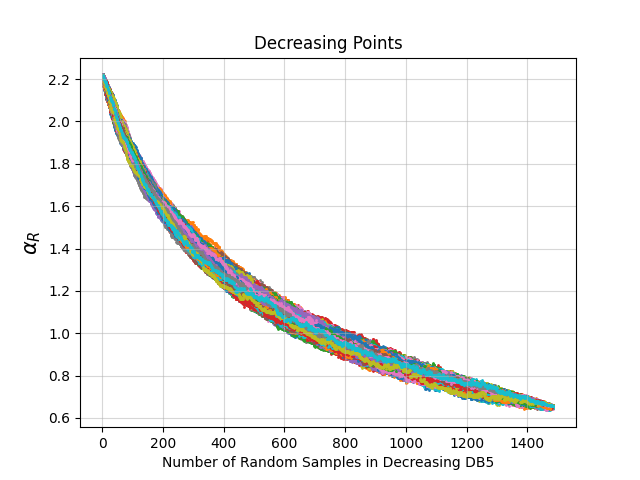

In [30]:
%matplotlib notebook

for s in small_dataset.index:
    plt.scatter( range(1, len(small_dataset.columns)+1) , small_dataset.loc[s].values, s=1)
plt.title("Decreasing Points")
plt.xlabel("Number of Random Samples in Decreasing DB5")
plt.ylabel("$\\alpha_R$", fontsize=15)

plt.grid(alpha=0.5)

<IPython.core.display.Javascript object>


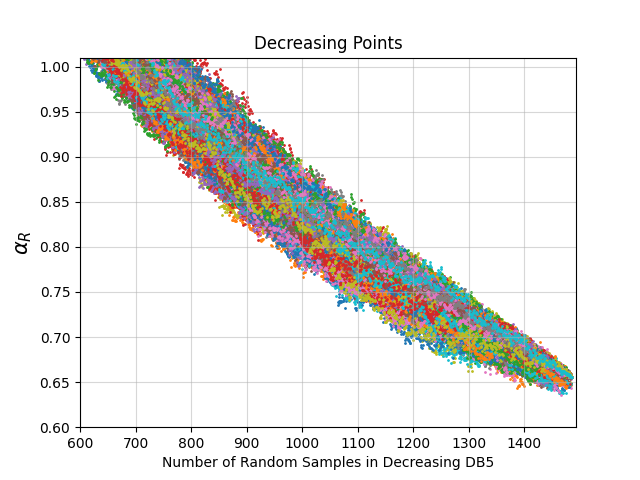

In [31]:
%matplotlib notebook

for s in small_dataset.index:
    plt.scatter( range(1, len(small_dataset.columns)+1) , small_dataset.loc[s].values, s=1)
plt.title("Decreasing Points")
plt.xlabel("Number of Random Samples in Decreasing DB5")
plt.ylabel("$\\alpha_R$", fontsize=15)

plt.grid(alpha=0.5)
ax = plt.gca()
ax.set_ylim([0.6, 1.01])
ax.set_xlim([600, len(small_dataset.columns)*1.005])
#plt.savefig("decreased_dataset_500_decreased_pts_zoom.jpg", format="jpg", dpi=800);

In [32]:
# Dataset with 1388, 0.64385

In [35]:
min(small_dataset["subset_1388"])

0.6438541414027651

In [37]:
# Seed
small_dataset.index[np.argmin(small_dataset["subset_1388"])]

2414

In [41]:
(1 - 1388/(len(R)+len(DB2)))*100

77.79910428662828

In [43]:
77.8 + 22.2

100.0